In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# We get the data file "Colab Notebooks"
path = "/content/drive/My Drive/Colab Notebooks"

In [0]:
datapath = path + "/part2_data/"

In [0]:
# import libraries
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torchtext import data
from torchtext.data import TabularDataset

In [5]:
import nltk
nltk.download('punkt')
from nltk import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


**Define custom Tabular Dataset**

In [0]:
txt_field = data.Field(
    tokenize=word_tokenize,
    lower=True,
    include_lengths=True,
    batch_first=True
)

In [0]:
label_field = data.Field(
    sequential=False,
    use_vocab=False,
    batch_first=True
)

In [0]:
fields = [('label', label_field), ('text', txt_field)]

In [0]:
train_d, valid_d, test_d = TabularDataset.splits(
    path=datapath,
    format='csv',
    train='train.csv',
    validation="validation.csv",
    test="test.csv",
    fields=fields,
    skip_header=True
)

**Baseline Parameters and setup device**

In [0]:
batch_size = 32

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

**Build vocab and load the iterators**

In [0]:
txt_field.build_vocab(train_d, min_freq = 3)

In [0]:
label_field.build_vocab(train_d)

In [0]:
train_iter, valid_iter, test_iter = data.BucketIterator.splits(
    (train_d, valid_d, test_d),
    batch_size=batch_size,
    sort_key= lambda x: len(x.text),
    sort_within_batch=True,
    device=device
)

**Set Up RNN Baseline Model**

In [0]:
embed_dim = 64
hidden_dim = 128
dropout = 0.5

In [0]:
class RNN(nn.Module):
  def __init__(self, n_vocab, mode, bidirectional, embedding):
    super(RNN, self).__init__()
    self.isEmbedding = embedding
    self.mode = mode

    self.emb_layer = nn.Embedding(n_vocab, embed_dim)
    self.fc = nn.Linear(hidden_dim * (1 + bidirectional), 1)
    self.sig = nn.Sigmoid()

    if mode == 'LSTM':
      if embedding:
        self.rnn_layer = nn.LSTM(
          input_size=embed_dim,
          hidden_size=hidden_dim,
          num_layers=1,
          dropout=dropout,
          batch_first=True,
          bidirectional=bidirectional
        )
      else:
        self.rnn_layer = nn.LSTM(
          input_size=1,
          hidden_size=hidden_dim,
          num_layers=1,
          dropout=dropout,
          batch_first=True,
          bidirectional=bidirectional
        )
    elif mode == 'GRU':
      self.rnn_layer = nn.GRU(
          input_size=embed_dim,
          hidden_size=hidden_dim,
          num_layers=1,
          dropout=dropout,
          batch_first=True,
          bidirectional=bidirectional
      )
    else:
      self.rnn_layer = nn.RNN(
          input_size=embed_dim,
          hidden_size=hidden_dim,
          num_layers=1,
          dropout=dropout,
          batch_first=True,
      )

  def forward(self, text, text_len):

    # as inputs is different for not embedding
    if self.isEmbedding:
      embedded = self.emb_layer(text)
    else:
      embedded = text.float().reshape(text.size(0), text.size(1), 1)

    # as outputs have difference, so check here
    if self.mode == 'LSTM':
      rnn_outs, (hidden, cell) = self.rnn_layer(embedded)
    else:
      rnn_outs, hidden = self.rnn_layer(embedded)

    
    feature_map = torch.cat([hidden[i, :, :] for i in range(hidden.shape[0])], dim=1)
    outputs = self.fc(feature_map)

    # as base model don't have sigmoid
    if self.mode == 'base':
      return outputs
    else:
      return self.sig(outputs)

**Set up model objects here**

In [0]:
len_vocab = len(txt_field.vocab)
# following are based on section 5.2

In [18]:
m1 = RNN(
    n_vocab=len_vocab, 
    mode='GRU', 
    bidirectional=False,
    embedding=True  
)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [19]:
m2 = RNN(
    n_vocab=len_vocab, 
    mode='LSTM', 
    bidirectional=False,
    embedding=True  
)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [20]:
m3 = RNN(
    n_vocab=len_vocab, 
    mode='LSTM', 
    bidirectional=True,
    embedding=True  
)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [99]:
m4 = RNN(
    n_vocab=len_vocab, 
    mode='LSTM', 
    bidirectional=False,
    embedding=False
)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [0]:
# print model achitecture and total number of parameters
def count_parameters(model):
    temp = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'The model architecture:\n\n', model)
    print(f'\nThe model has {temp:,} trainable parameters')
    print()

In [46]:
models = [m1, m2, m3, m4]

for m in models:
  count_parameters(m)

The model architecture:

 RNN(
  (emb_layer): Embedding(51167, 64)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sig): Sigmoid()
  (rnn_layer): GRU(64, 128, batch_first=True, dropout=0.5)
)

The model has 3,349,313 trainable parameters

The model architecture:

 RNN(
  (emb_layer): Embedding(51167, 64)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sig): Sigmoid()
  (rnn_layer): LSTM(64, 128, batch_first=True, dropout=0.5)
)

The model has 3,374,145 trainable parameters

The model architecture:

 RNN(
  (emb_layer): Embedding(51167, 64)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
  (rnn_layer): LSTM(64, 128, batch_first=True, dropout=0.5, bidirectional=True)
)

The model has 3,473,601 trainable parameters

The model architecture:

 RNN(
  (emb_layer): Embedding(51167, 64)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sig): Sigmoid()
  (rnn_layer): LSTM(1, 128, batch_first=True, dropout=0.5)
)

The model ha

**Define save, load, train function**

In [0]:
# from tutorial 7
def save_m(save_path, model, optimizer, val_loss):
  if save_path == None:
    return

  state = {
      'model_state': model.state_dict(),
      'optimizer_state': optimizer.state_dict(),
      'val_loss': val_loss
  }

  torch.save(state, save_path)
  print(f'Model saved to ==> {save_path}')

In [0]:
def load_m(model, optimizer, save_path):
  state = torch.load(save_path)

  model.load_state_dict(state['model_state'])
  optimizer.load_state_dict(state['optimizer_state'])
  
  print(f'Model loaded from <== {save_path}')

  return state['val_loss']

In [0]:
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    rounded_preds = torch.round(preds)
    
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc

In [0]:
def RefactorTrain(mode, device, model, optimizer, sent, sent_len, labels, criterion):
  if mode == 'train':
    optimizer.zero_grad()

  outputs = model(sent, sent_len).squeeze()

  labels = labels.float()

  loss = criterion(outputs, labels)
  acc = binary_accuracy(outputs, labels)

  if mode == 'train':
    loss.backward()
    optimizer.step()

  return loss.item(), acc.item()

In [0]:
def TRAIN( 
    device, model, num_epochs, eval_every, total_step,
    train_loader, valid_loader, criterion, optimizer,
    val_loss, save_path
):
  running_loss = 0.0
  running_acc = 0.0
  running_n = 0
  global_step = 0
  if val_loss == None:
    best_val_loss = float("Inf")
  else:
    best_val_loss = val_loss

  # drop plot details here
  r_train_loss = []
  r_val_loss = []
  r_steps = []

  print ("Start training:")

  for epoch in range(num_epochs):

    for i, batch in enumerate(train_loader):
      model.train() # switch to train mode

      sent, sent_len = batch.text
      labels = batch.label
      r, a = RefactorTrain('train', device, model, optimizer, sent, sent_len, labels, criterion)
      
      running_loss += r
      running_acc += a
      running_n += len(labels)
      global_step += 1

      if global_step % (eval_every / 10) == 0:
        print ('#', end="")

      if global_step % eval_every == 0:
        # evaluate
        with torch.no_grad():
          model.eval()
          print ("")
          print ('Start evaluating')
          val_r_loss = 0.0
          val_acc = 0.0
          val_running_n = 0

          for vbatch in valid_loader:
            vi, vi_len = vbatch.text
            vl = vbatch.label
            vr, va = RefactorTrain('eval', device, model, optimizer, vi, vi_len, vl, criterion)
            val_r_loss += vr
            val_acc += va
            val_running_n += len(vl)

          avg_train_loss = running_loss / eval_every
          avg_val_loss = val_r_loss / float(len(valid_loader))
          avg_train_acc = running_acc / float(running_n)
          avg_val_acc = val_acc / float(val_running_n)

          print(
              'Epoch [{}/{}], Step [{}/{}]'.format(
                  epoch+1, num_epochs, global_step, total_step
              )
          )
          print(
              'Training Loss: {:.8f}, Validate Loss: {:.8f}'.format(
                  avg_train_loss, avg_val_loss
              )
          )
          print(
              'Training Accuracy: {:.8f}, Validate Accuracy: {:.8f}'.format(
                  avg_train_acc, avg_val_acc
              )
          )

          r_steps.append(global_step)
          r_train_loss.append(avg_train_loss)
          r_val_loss.append(avg_val_loss)

          # reset train loss and check save
          running_loss = 0.0
          running_n = 0
          running_acc = 0.0
          if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            save_m(save_path, model, optimizer, best_val_loss)

  return r_train_loss, r_val_loss, r_steps

**Train here**

In [0]:
criterion = nn.BCEWithLogitsLoss()
save_path = "./part2"
n_epochs = 10
eval_every = 750
total_step = len(train_iter) * n_epochs
val_loss = None

In [30]:
# Baseline model
base = RNN(
    n_vocab=len_vocab,
    mode='base',
    bidirectional=False,
    embedding=True
)

base.to(device)
optimizer = torch.optim.Adam(base.parameters(), lr=0.001)
bts, bvs, bss = TRAIN(
    device, base, n_epochs, eval_every, total_step,
    train_iter, valid_iter, criterion, optimizer, val_loss, save_path
)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Start training:
##########
Start evaluating
Epoch [1/10], Step [750/12500]
Training Loss: 0.69134624, Validate Loss: 0.69396991
Training Accuracy: 0.01511068, Validate Accuracy: 0.01566250
Model saved to ==> ./part2
##########
Start evaluating
Epoch [2/10], Step [1500/12500]
Training Loss: 0.68764527, Validate Loss: 0.69160599
Training Accuracy: 0.01541406, Validate Accuracy: 0.01566250
Model saved to ==> ./part2
##########
Start evaluating
Epoch [2/10], Step [2250/12500]
Training Loss: 0.69219763, Validate Loss: 0.69321339
Training Accuracy: 0.01525911, Validate Accuracy: 0.01566250
##########
Start evaluating
Epoch [3/10], Step [3000/12500]
Training Loss: 0.69270508, Validate Loss: 0.69221675
Training Accuracy: 0.01534505, Validate Accuracy: 0.01566250
##########
Start evaluating
Epoch [3/10], Step [3750/12500]
Training Loss: 0.69576138, Validate Loss: 0.69485775
Training Accuracy: 0.01566016, Validate Accuracy: 0.01566250
##########
Start evaluating
Epoch [4/10], Step [4500/12500]
T

In [31]:
# afraid of error, spilit to train
m1.to(device)
optimizer = torch.optim.Adam(m1.parameters(), lr=0.001)

print ('Training model 1')

m1ts, m1vs, m1ss = TRAIN(
    device, m1, n_epochs, eval_every, total_step,
    train_iter, valid_iter, criterion, optimizer, val_loss, save_path
)

Training model 1
Start training:
##########
Start evaluating
Epoch [1/10], Step [750/12500]
Training Loss: 0.69321668, Validate Loss: 0.68617907
Training Accuracy: 0.01564844, Validate Accuracy: 0.01635000
Model saved to ==> ./part2
##########
Start evaluating
Epoch [2/10], Step [1500/12500]
Training Loss: 0.69669692, Validate Loss: 0.68886940
Training Accuracy: 0.01569661, Validate Accuracy: 0.01596875
##########
Start evaluating
Epoch [2/10], Step [2250/12500]
Training Loss: 0.67270989, Validate Loss: 0.63744894
Training Accuracy: 0.01796094, Validate Accuracy: 0.02114375
Model saved to ==> ./part2
##########
Start evaluating
Epoch [3/10], Step [3000/12500]
Training Loss: 0.60580349, Validate Loss: 0.58957022
Training Accuracy: 0.02424609, Validate Accuracy: 0.02618750
Model saved to ==> ./part2
##########
Start evaluating
Epoch [3/10], Step [3750/12500]
Training Loss: 0.57082229, Validate Loss: 0.57060613
Training Accuracy: 0.02660286, Validate Accuracy: 0.02631875
Model saved to ==

In [32]:
m2.to(device)
optimizer = torch.optim.Adam(m2.parameters(), lr=0.001)

print ('Training model 2')

m2ts, m2vs, m2ss = TRAIN(
    device, m2, n_epochs, eval_every, total_step,
    train_iter, valid_iter, criterion, optimizer, val_loss, save_path
)

Training model 2
Start training:
##########
Start evaluating
Epoch [1/10], Step [750/12500]
Training Loss: 0.69367096, Validate Loss: 0.69304428
Training Accuracy: 0.01565625, Validate Accuracy: 0.01566250
Model saved to ==> ./part2
##########
Start evaluating
Epoch [2/10], Step [1500/12500]
Training Loss: 0.69251595, Validate Loss: 0.67724032
Training Accuracy: 0.01565104, Validate Accuracy: 0.01730625
Model saved to ==> ./part2
##########
Start evaluating
Epoch [2/10], Step [2250/12500]
Training Loss: 0.66608400, Validate Loss: 0.65348597
Training Accuracy: 0.01937370, Validate Accuracy: 0.02135000
Model saved to ==> ./part2
##########
Start evaluating
Epoch [3/10], Step [3000/12500]
Training Loss: 0.64514742, Validate Loss: 0.69133369
Training Accuracy: 0.02023047, Validate Accuracy: 0.01581250
##########
Start evaluating
Epoch [3/10], Step [3750/12500]
Training Loss: 0.66900139, Validate Loss: 0.62367380
Training Accuracy: 0.01822396, Validate Accuracy: 0.02198125
Model saved to ==

In [33]:
m3.to(device)
optimizer = torch.optim.Adam(m3.parameters(), lr=0.001)

print ('Training model 3')

m3ts, m3vs, m3ss = TRAIN(
    device, m3, n_epochs, eval_every, total_step,
    train_iter, valid_iter, criterion, optimizer, val_loss, save_path
)

Training model 3
Start training:
##########
Start evaluating
Epoch [1/10], Step [750/12500]
Training Loss: 0.69210099, Validate Loss: 0.67762338
Training Accuracy: 0.01585677, Validate Accuracy: 0.01723750
Model saved to ==> ./part2
##########
Start evaluating
Epoch [2/10], Step [1500/12500]
Training Loss: 0.69414761, Validate Loss: 0.69307454
Training Accuracy: 0.01618490, Validate Accuracy: 0.01566250
##########
Start evaluating
Epoch [2/10], Step [2250/12500]
Training Loss: 0.67161819, Validate Loss: 0.62793406
Training Accuracy: 0.01779688, Validate Accuracy: 0.02288125
Model saved to ==> ./part2
##########
Start evaluating
Epoch [3/10], Step [3000/12500]
Training Loss: 0.59894736, Validate Loss: 0.58525042
Training Accuracy: 0.02450521, Validate Accuracy: 0.02540000
Model saved to ==> ./part2
##########
Start evaluating
Epoch [3/10], Step [3750/12500]
Training Loss: 0.57528773, Validate Loss: 0.59252291
Training Accuracy: 0.02627344, Validate Accuracy: 0.02416250
##########
Start 

In [100]:
m4.to(device)
optimizer = torch.optim.Adam(m4.parameters(), lr=0.001)

print ('Training model 4')

m4ts, m4vs, m4ss = TRAIN(
    device, m4, n_epochs, eval_every, total_step,
    train_iter, valid_iter, criterion, optimizer, val_loss, save_path
)

Training model 4
Start training:
##########
Start evaluating
Epoch [1/10], Step [750/12500]
Training Loss: 0.69333984, Validate Loss: 0.69311272
Training Accuracy: 0.01557812, Validate Accuracy: 0.01566250
Model saved to ==> ./part2
##########
Start evaluating
Epoch [2/10], Step [1500/12500]
Training Loss: 0.69313771, Validate Loss: 0.69303112
Training Accuracy: 0.01566276, Validate Accuracy: 0.01566250
Model saved to ==> ./part2
##########
Start evaluating
Epoch [2/10], Step [2250/12500]
Training Loss: 0.69318719, Validate Loss: 0.69300372
Training Accuracy: 0.01560937, Validate Accuracy: 0.01566250
Model saved to ==> ./part2
##########
Start evaluating
Epoch [3/10], Step [3000/12500]
Training Loss: 0.69310550, Validate Loss: 0.69276939
Training Accuracy: 0.01570703, Validate Accuracy: 0.01566250
Model saved to ==> ./part2
##########
Start evaluating
Epoch [3/10], Step [3750/12500]
Training Loss: 0.69311466, Validate Loss: 0.69235895
Training Accuracy: 0.01556771, Validate Accuracy: 0

**Plot graphs**

In [0]:
import matplotlib.pyplot as plt

Start evaluating using testing set with progress bar: #

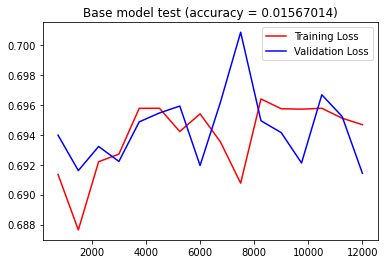

In [86]:
# Q7
def eval(model):
  corrs = 0
  running_n = 0
  total = len(test_iter)
  with torch.no_grad():
    print ('Start evaluating using testing set with progress bar: ', end="")
    for i, batch in enumerate(test_iter):
      if i % (total / 10) == 0:
        print ('#', end="")
      
      sent, sent_len = batch.text
      labels = batch.label.float()

      model.eval()
      outputs = model(sent, sent_len).squeeze()
      loss = criterion(outputs, labels)
      acc = binary_accuracy(outputs, labels)
      corrs += acc.item()
      running_n += len(labels)
  
  return corrs / float(running_n)

base_acc = eval(base)
plt.plot(bss, bts, c='red', label="Training Loss")
plt.plot(bss, bvs, c='blue', label="Validation Loss")
plt.title('Base model test (accuracy = {:.8f})'.format(base_acc))
plt.legend()
plt.show()

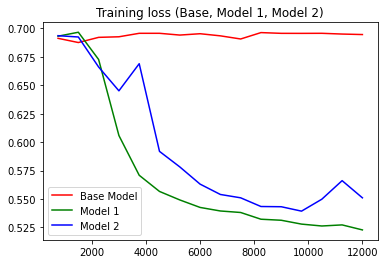

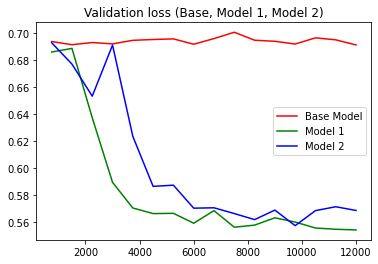

In [64]:
# Q8
plt.plot(bss, bts, c='red', label="Base Model")
plt.plot(m1ss, m1ts, c='green', label="Model 1")
plt.plot(m2ss, m2ts, c='blue', label="Model 2")
plt.title('Training loss (Base, Model 1, Model 2)')
plt.legend()
plt.show()

plt.plot(bss, bvs, c='red', label="Base Model")
plt.plot(m1ss, m1vs, c='green', label="Model 1")
plt.plot(m2ss, m2vs, c='blue', label="Model 2")
plt.title('Validation loss (Base, Model 1, Model 2)')
plt.legend()
plt.show()

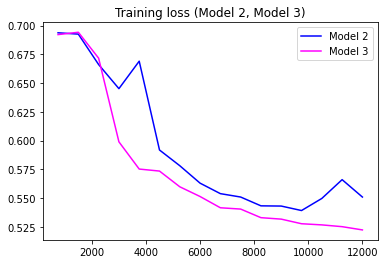

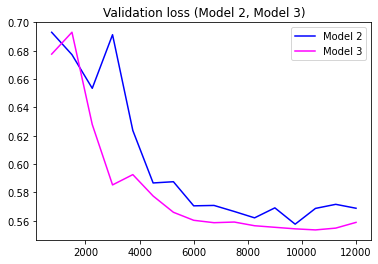

In [65]:
# Q9
plt.plot(m2ss, m2ts, c='blue', label="Model 2")
plt.plot(m3ss, m3ts, c='magenta', label="Model 3")
plt.title('Training loss (Model 2, Model 3)')
plt.legend()
plt.show()

plt.plot(m2ss, m2vs, c='blue', label="Model 2")
plt.plot(m3ss, m3vs, c='magenta', label="Model 3")
plt.title('Validation loss (Model 2, Model 3)')
plt.legend()
plt.show()

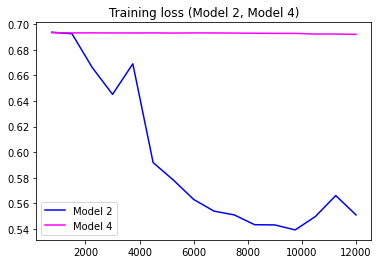

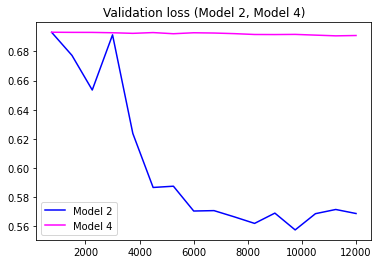

In [101]:
# Q10
plt.plot(m2ss, m2ts, c='blue', label="Model 2")
plt.plot(m4ss, m4ts, c='magenta', label="Model 4")
plt.title('Training loss (Model 2, Model 4)')
plt.legend()
plt.show()

plt.plot(m2ss, m2vs, c='blue', label="Model 2")
plt.plot(m4ss, m4vs, c='magenta', label="Model 4")
plt.title('Validation loss (Model 2, Model 4)')
plt.legend()
plt.show()

In [102]:
# Q11
models = [m1, m2, m3, m4]

for i, m in enumerate(models):
  print ('Accuracy of model {}, {:.8f}'.format(i, eval(m)) )

Start evaluating using testing set with progress bar: #Accuracy of model 0, 0.02805556
Start evaluating using testing set with progress bar: #Accuracy of model 1, 0.02701042
Start evaluating using testing set with progress bar: #Accuracy of model 2, 0.02806597
Start evaluating using testing set with progress bar: #Accuracy of model 3, 0.01608681


**Do Predictions**

In [0]:
# get submission dataset
submission = TabularDataset(
    path=datapath+'submission.csv',
    format='csv',
    fields=fields,
    skip_header=True
)

In [0]:
sub_iter = data.BucketIterator(
    submission,
    batch_size=1,
    device=device
)

In [0]:
model = m3

In [0]:
results = []
with torch.no_grad():
  for i, batch in enumerate(sub_iter):
    model.eval()
    text, text_len = batch.text

    outputs = model(text, text_len).squeeze()
    outputs = torch.round(outputs).int()
    pred = torch.Tensor.cpu(outputs).detach()
    results.append( pred.item() )

In [82]:
import pandas as pd

df = pd.read_csv(datapath + 'submission.csv')
df['label'] = results
df

,label,text
0,1,Less self-conscious and much less pretentious ...
1,0,I thought that One Dark Night was great! It de...
2,1,I wish I had something more positive to say ab...
3,1,Easily 9 out of 10 for a film by director we w...
4,1,"One missed call, another Asian horror based on..."
...,...,...
1995,0,So umm this woman has a vagina that sucks peop...
1996,1,A sequel to actually a remake of Disney's 1996...
1997,0,Why can't more directors these days create hor...
1998,1,Turkish-German director Faith Ak n Head-On The...


In [0]:
# export csv and copy it back to path
df.to_csv('part2.csv', index=False)
!cp part2.csv path

**L2 Distance**